In [1]:
import numpy as np
from utils import ExtractActivities
from StringIO import StringIO

filename = "./data/ann.txt"
activities = ExtractActivities(filename)
file_bin_sensors = "./data/bin_sensors.txt"
bin_sensors = np.loadtxt(file_bin_sensors,dtype=np.str)
con_sensors = np.loadtxt("./data/continue_sensors.txt",dtype=np.str)

清理数据：只保留二值传感器

In [2]:
def onlybin(activity):
    bin_activity = [activity[0]]
    for i in range(1,len(activity)):
        if len(activity[i]) == 4 and activity[i][2] in bin_sensors:
            bin_activity.append(activity[i])
    return bin_activity
        

剔除其他类型传感器，获取只含有二值传感器的行为序列

In [3]:
"""
刚开始只测试前20个行为序列，数据量小，计算快
"""

activities = ExtractActivities(filename)
# print onlybin(activities[0])
bin_activities = []
# for activity in activities[0:20]:
for activity in activities:
    bin_activities.append(onlybin(activity))
print bin_activities[0]
bin_activities = np.array(bin_activities)
activity_labels = [activity[0] for activity in bin_activities]
print bin_activities.shape

['Sleep', ['2011-06-15', '02:13:20.812509', 'M007', 'ON'], ['2011-06-15', '02:13:21.919635', 'M007', 'OFF'], ['2011-06-15', '05:40:14.111389', 'M021', 'ON']]
(2655L,)


计算TF（SF），传感器在当前活动中出现的频率

pandas.dataframe

1、计算每个行为序列中激发每种传感器的次数
2、通过次数计算频率
3、计算TF


In [6]:
import pandas as pd
# print bin_sensors
df_activity_sensor = pd.DataFrame(index=np.arange(bin_activities.shape[0]),columns=bin_sensors)
activity_sensor_times = np.array([[0 for x in range(len(bin_sensors))] 
                                  for i in range(len(bin_activities))],dtype=np.float16)

for i in range(0,len(bin_activities)):
    current_act = bin_activities[i]
    for j in range(1,len(current_act)):
        col_index = list(bin_sensors).index(current_act[j][2])
        activity_sensor_times[i,col_index] += 1
total_times = activity_sensor_times.sum(axis=1)
tf = activity_sensor_times / total_times[:,np.newaxis]
print tf.shape

(2655L, 37L)


计算DF（AF）
1、计算出现该传感器的活动数
2、计算频数






In [8]:
ac_one = np.zeros((len(bin_activities),len(bin_sensors)))
for i in range(ac_one.shape[0]):
    for j in range(ac_one.shape[1]):
        if activity_sensor_times[i,j] > 0:
            ac_one[i,j] = 1
is_has_sensor = ac_one.sum(axis=1)  
# 文档频率
df = float(ac_one.shape[0])/is_has_sensor
idf = np.log((df+0.01))
print idf.shape




(2655L,)


计算tf-idf

In [9]:
sensor_weight = tf * idf[:,np.newaxis]

df_sensor_weights = pd.DataFrame(sensor_weight,columns=bin_sensors,
                                 index=range(len(bin_activities)))
df_sensor_weights.insert(0,'label',activity_labels)
df_sensor_weights[df_sensor_weights['label']=='Eat'].describe()

,D002,D003,D004,D005,D006,L001,L002,L003,L004,L005,...,M015,M016,M017,M018,M020,M021,MA019,MA022,MA023,MA024
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,...,36.0,36.000000,36.0,36.0,36.000000,36.0,36.0,36.000000,36.000000,36.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.553879,0.0,0.0,0.004098,0.0,0.0,0.903501,0.086392,0.183703
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.633731,0.0,0.0,0.024591,0.0,0.0,0.519608,0.223123,0.772243
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.522875,0.0,0.0,0.000000,0.0,0.0,0.601303,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.983783,0.0,0.0,0.000000,0.0,0.0,0.885977,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.406294,0.0,0.0,0.000000,0.0,0.0,1.198217,0.000000,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.884204,0.0,0.0,0.147545,0.0,0.0,2.431547,0.999436,3.637982


计算每种传感器对每一类行为的重要程度

分类

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

%matplotlib inline
# 用sklearn的learning_curve得到training_score和cv_score，使用matplotlib画出learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("training num")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="score on train")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="score on cv")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff


调参方法

In [200]:
from __future__ import print_function

from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC



def findParameters(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.5, random_state=0)

    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    # scores = ['precision_macro']

    # clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
    # clf.fit(X_train, y_train)

    # for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


tf-idf 调参

In [ ]:
X = sensor_weight
Y = activity_labels   
findParameters(X,Y)

tf-idf 分类性能

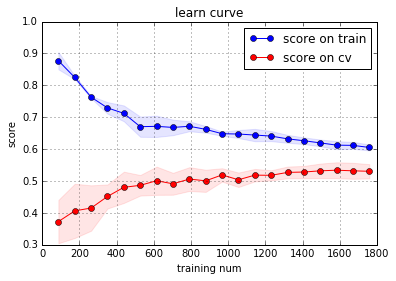

(0.56140636346720529, 0.10652915099631566)

In [196]:
clf = SVC(kernel='linear',C=1000)
plot_learning_curve(clf, "learn curve", X, Y)

是否出现调参

In [199]:

X = ac_one
Y = activity_labels    
findParameters(X,Y)

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'kernel': 'linear', 'C': 1}

Grid scores on development set:

0.179 (+/-0.011) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.179 (+/-0.011) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.483 (+/-0.021) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
0.179 (+/-0.011) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001}
0.552 (+/-0.018) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.485 (+/-0.019) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.558 (+/-0.034) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.551 (+/-0.024) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}
0.561 (+/-0.026) for {'kernel': 'linear', 'C': 1}
0.553 (+/-0.030) for {'kernel': 'linear', 'C': 10}
0.555 (+/-0.035) for {'kernel': 'linear', 'C': 100}
0.554 (+/-0.030) for {'kernel': 'linear', 'C': 1000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation

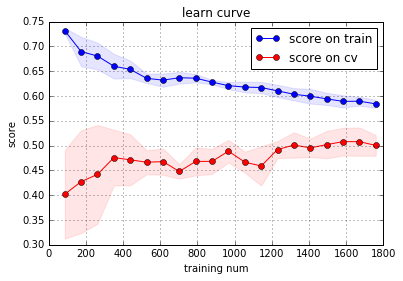

(0.5360323511537245, 0.11280917362350684)

In [201]:
clf = SVC(kernel='linear',C=1)
plot_learning_curve(clf, "learn curve", X, Y)

# 改进tf-idf算法：增加信息熵

In [41]:
# activity_labels = np.array(activity_labels)
# current_activity_index = (activity_labels == "Sleep")
# current_activity_times = sum(current_activity_index)
# print current_activity_times
# # print current_activity_index.shape
# current_activity_sensor_weight = sensor_weight[current_activity_index]
# # 得到当前类中出现的所有传感器下标
# index = current_activity_sensor_weight.sum(axis=0)>0

# # 获取当前行为触发的所有传感器ID
# current_activity_sensor = bin_sensors[index]
# # print current_activity_sensor
# # print len(activity_sensor)
# current_activity_sensor_times = activity_sensor_times[:,index]
# print current_activity_sensor_times.sum(axis=0)


106
[  1021.     92.    952.    828.    662.  13928.    155.    424.    102.
   3508.    563.  17440.    932.   6768.    925.    791.   1006.   1040.
  15984.   6852.   1136.    181.   4976.  18304.  15248.]


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2655 but corresponding boolean dimension is 37


In [77]:
activity_labels = np.array(activity_labels)
current_activity_index = (activity_labels == "Sleep")
# 该类行为的传感器次数矩阵，包含所有的传感器
current_activity_sensor_times = activity_sensor_times[current_activity_index]

# 该类行为出现的总次数
current_activity_times = sum(current_activity_index)

# 该类行为的传感器权重
current_activity_sensor_weight = sensor_weight[current_activity_index]

# 得到当前类中出现的所有传感器下标
index = current_activity_sensor_weight.sum(axis=0)>0

# 获取当前行为触发的所有传感器ID
current_activity_actsensor = bin_sensors[index]
print current_activity_actsensor
# 该类行为触发的所有传感器次数，只包含触发的传感器
current_activity_actsensor_times = current_activity_sensor_times[:,index]
print current_activity_actsensor_times[3]

sensor_entry_inner_class = 



['M001' 'M002' 'M003' 'M005' 'M006' 'M007' 'M008' 'M010' 'M011' 'M012'
 'M014' 'M015' 'M016' 'M017' 'M018' 'M020' 'M021' 'MA019' 'MA022' 'MA023'
 'MA024']
[  0.   0.   0.   0.   0.  20.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
